# Install library

In [3]:
!pip install panda lxml bs4 httpx backtesting yfinance pandas_ta scipy rich matplotlib mplfinance keras tensorflow pymc3

# import library

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime

In [5]:
import concurrent.futures
from datetime import datetime
import glob
import warnings
from rich.progress import track
warnings.filterwarnings("ignore")
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas_ta as taPanda
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from collections import Counter
import httpx

# Utilities Function

In [6]:
def make_api_request(api_endpoint, params):
    with httpx.Client() as client:
        # Make the GET request to the API
        response = client.get(api_endpoint, params=params)
        if response.status_code == 200:
            return response.json()
        print("Error: Failed to retrieve data from API")
        return None

In [7]:
BASE_URL_FMP = "https://financialmodelingprep.com/api/v3"
BASE_URL_BINANCE = "https://fapi.binance.com/fapi/v1/"

FMP_API_KEY = "17c09553207c6d6e7bab10003e604aa8"
BINANCE_API_KEY = ""

In [8]:
def get_historical_price_full_crypto(symbol):
    api_endpoint = f"{BASE_URL_FMP}/historical-price-full/crypto/{symbol}"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)


def get_historical_price_full_stock(symbol):
    api_endpoint = f"{BASE_URL_FMP}/historical-price-full/{symbol}"
    params = {"apikey": FMP_API_KEY}

    return make_api_request(api_endpoint, params)

def get_SP500():
    api_endpoint = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    data = pd.read_html(api_endpoint)
    return list(data[0]['Symbol'])

def get_all_crypto():
    """
    All possible crypto symbols
    """
    return [
        "BTCUSD",
        "ETHUSD",
        "LTCUSD",
        "BCHUSD",
        "XRPUSD",
        "EOSUSD",
        "XLMUSD",
        "TRXUSD",
        "ETCUSD",
        "DASHUSD",
        "ZECUSD",
        "XTZUSD",
        "XMRUSD",
        "ADAUSD",
        "NEOUSD",
        "XEMUSD",
        "VETUSD",
        "DOGEUSD",
        "OMGUSD",
        "ZRXUSD",
        "BATUSD"
        "USDTUSD",
        "LINKUSD",
        "BTTUSD",
        "BNBUSD",
        "ONTUSD",
        "QTUMUSD",
        "ALGOUSD",
        "ZILUSD",
        "ICXUSD",
        "KNCUSD",
        "ZENUSD",
        "THETAUSD",
        "IOSTUSD",
        "ATOMUSD",
        "MKRUSD",
        "COMPUSD",
        "YFIUSD",
        "SUSHIUSD",
        "SNXUSD",
        "UMAUSD",
        "BALUSD",
        "AAVEUSD",
        "UNIUSD",
        "RENBTCUSD",
        "RENUSD",
        "CRVUSD",
        "SXPUSD",
        "KSMUSD",
        "OXTUSD",
        "DGBUSD",
        "LRCUSD",
        "WAVESUSD",
        "NMRUSD",
        "STORJUSD",
        "KAVAUSD",
        "RLCUSD",
        "BANDUSD",
        "SCUSD",
        "ENJUSD",
    ]

def get_financial_statements_lists():
    api_endpoint = f"{BASE_URL_FMP}/financial-statement-symbol-lists"
    params = {"apikey": FMP_API_KEY}
    return make_api_request(api_endpoint, params)

# Split the Data into Train and Test

In [9]:
stock_symbol = "AAPL"
stock_prices = get_historical_price_full_stock(stock_symbol)

data = pd.DataFrame(stock_prices['historical'])

In [10]:
data

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2024-01-26,194.27,194.7600,191.9400,192.42,192.42,44566855,41708329,-1.85,-0.952280,193.12,"January 26, 24",-0.009523
1,2024-01-25,195.22,196.2675,193.1125,194.17,194.17,54822126,54822100,-1.05,-0.537850,194.73,"January 25, 24",-0.005378
2,2024-01-24,195.42,196.3800,194.3400,194.50,194.50,53631316,53631300,-0.92,-0.470780,195.21,"January 24, 24",-0.004708
3,2024-01-23,195.02,195.7500,193.8299,195.18,195.18,42355590,42355600,0.16,0.082043,194.82,"January 23, 24",0.000820
4,2024-01-22,192.30,195.3300,192.2600,193.89,193.89,60131852,60133900,1.59,0.826830,193.99,"January 22, 24",0.008268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,2019-02-01,41.74,42.2400,41.4800,41.63,39.96,130672400,130672400,-0.11,-0.263540,41.79,"February 01, 19",-0.002635
1255,2019-01-31,41.53,42.2500,41.1400,41.61,39.94,162958400,162958400,0.08,0.192630,41.67,"January 31, 19",0.001926
1256,2019-01-30,40.81,41.5400,40.0600,41.31,39.65,244439200,244439200,0.50,1.230000,40.97,"January 30, 19",0.012300
1257,2019-01-29,39.06,39.5300,38.5300,38.67,37.12,166348800,166348800,-0.39,-0.998460,38.91,"January 29, 19",-0.009985


In [11]:
january_2023_index = data[(data['date'] < '2023-01-01')].index
january_2023_index

Index([ 268,  269,  270,  271,  272,  273,  274,  275,  276,  277,
       ...
       1249, 1250, 1251, 1252, 1253, 1254, 1255, 1256, 1257, 1258],
      dtype='int64', length=991)

In [12]:
prices_before_january_2023 = data.loc[january_2023_index]
prices_before_january_2023

# Assuming prices_before_january_2023 is your DataFrame
prices_before_january_2023 = prices_before_january_2023.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'  # Only if you have a volume column
})

# Drop any additional columns that are not required
required_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
prices_before_january_2023 = prices_before_january_2023[required_columns]

# sort by date ascending
prices_before_january_2023 = prices_before_january_2023.sort_values(by=['date'], ascending=True)

prices_before_january_2023

,date,Open,High,Low,Close,Volume
1258,2019-01-28,38.95,39.08,38.42,39.08,104768400
1257,2019-01-29,39.06,39.53,38.53,38.67,166348800
1256,2019-01-30,40.81,41.54,40.06,41.31,244439200
1255,2019-01-31,41.53,42.25,41.14,41.61,162958400
1254,2019-02-01,41.74,42.24,41.48,41.63,130672400
...,...,...,...,...,...,...
272,2022-12-23,130.92,132.42,129.64,131.86,63814900
271,2022-12-27,131.38,131.41,128.72,130.03,69007800
270,2022-12-28,129.67,131.03,125.87,126.04,85438400
269,2022-12-29,127.99,130.48,127.73,129.61,75703700


In [13]:
prices_after_january_2023 = data.drop(january_2023_index)
prices_after_january_2023

# Assuming prices_after_january_2023 is your DataFrame
prices_after_january_2023 = prices_after_january_2023.rename(columns={
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'volume': 'Volume'  # Only if you have a volume column
})

# Drop any additional columns that are not required
required_columns = ['date', 'Open', 'High', 'Low', 'Close', 'Volume']
prices_after_january_2023 = prices_after_january_2023[required_columns]

# sort by date ascending
prices_after_january_2023 = prices_after_january_2023.sort_values(by=['date'], ascending=True)

prices_after_january_2023

,date,Open,High,Low,Close,Volume
267,2023-01-03,130.28,130.9000,124.1700,125.07,112117500
266,2023-01-04,126.89,128.6600,125.0800,126.36,89113600
265,2023-01-05,127.13,127.7700,124.7600,125.02,80962700
264,2023-01-06,126.01,130.2900,124.8900,129.62,87754700
263,2023-01-09,130.47,133.4100,129.8900,130.15,70790800
...,...,...,...,...,...,...
4,2024-01-22,192.30,195.3300,192.2600,193.89,60131852
3,2024-01-23,195.02,195.7500,193.8299,195.18,42355590
2,2024-01-24,195.42,196.3800,194.3400,194.50,53631316
1,2024-01-25,195.22,196.2675,193.1125,194.17,54822126


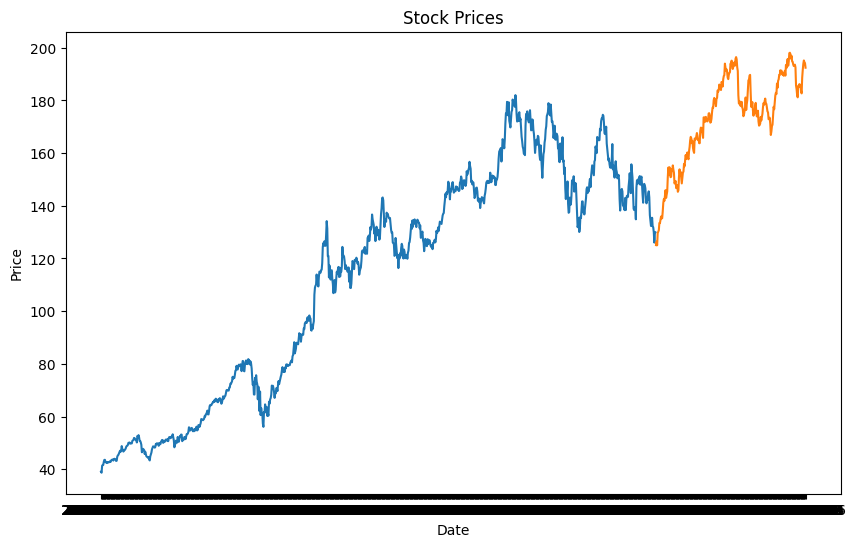

In [14]:
plt.figure(figsize=(10, 6))
plt.title('Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(prices_before_january_2023['date'], prices_before_january_2023['Close'])
plt.plot(prices_after_january_2023['date'], prices_after_january_2023['Close'])
plt.show()

# Monte Carlo Simulation

In [15]:
def monte_carlo_simulation(data, days, iterations):
    # Convert to numpy array if data is a pandas Series
    if isinstance(data, pd.Series):
        data = data.to_numpy()

    # Ensure data is a numpy array
    if not isinstance(data, np.ndarray):
        raise TypeError("Data must be a numpy array or pandas Series")

    # Calculate log returns
    log_returns = np.log(data[1:] / data[:-1])
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    drift = mean - (0.5 * variance)
    daily_volatility = np.std(log_returns)

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]
    for t in range(days):
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))
        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]
    return future_prices


In [16]:
def monte_carlo_simulation_with_dynamic_roulette(data, days, iterations, roulette_chance=0.05, extreme_factor=3):
    if isinstance(data, pd.Series):
        data = data.to_numpy()
    
    log_returns = np.log(data[1:] / data[:-1])

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]

    for t in range(days):
        # Update volatility based on recent data
        recent_log_returns = log_returns[-t-20:-t] if t >= 20 else log_returns
        daily_volatility = np.std(recent_log_returns)

        # Standard Monte Carlo step
        mean = np.mean(recent_log_returns)
        variance = np.var(recent_log_returns)
        drift = mean - (0.5 * variance)
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))

        # Russian Roulette logic remains the same...

        future_prices[t] = current_price * np.exp(shocks)
        current_price = future_prices[t]

    return future_prices


In [61]:
def monte_carlo_simulation_improved(data, days, iterations, volatility_lookback=200, stochastic_drift=False, time_step=1):
    if isinstance(data, pd.Series):
        data = data.to_numpy()

    log_returns = np.log(data[1:] / data[:-1])

    future_prices = np.zeros((days, iterations))
    current_price = data[-1]

    for t in range(days):
        # Update volatility based on recent data
        lookback_period = min(volatility_lookback, t + 1)
        recent_log_returns = log_returns[-lookback_period:]
        daily_volatility = np.std(recent_log_returns)

        # Stochastic drift
        if stochastic_drift:
            drift_volatility = daily_volatility * 0.2  # Adjust the factor as needed
            drift = np.random.normal(0, drift_volatility)

        else:
            mean = np.mean(recent_log_returns)
            variance = np.var(recent_log_returns)
            drift = mean - (0.5 * variance)

        # Standard Monte Carlo step
        shocks = drift + daily_volatility * norm.ppf(np.random.rand(iterations))

        future_prices[t] = current_price * np.exp(shocks) + data[-1]
        current_price = future_prices[t]

        # Varying time step
        current_price_time_step = int(t * time_step)
        if current_price_time_step >= len(data):
            break
        current_price = data[current_price_time_step]

    return future_prices


# Markov Chain Simulation Transition Matrix

In [17]:
bins = list(range(0, 210, 10)) + [np.inf]
strata = pd.cut(prices_before_january_2023['Close'], bins=bins)

transition_matrix = pd.crosstab(pd.Series(strata[:-1], name='Current'),
                                pd.Series(strata[1:], name='Next'),
                                normalize='index')

# Markov Chain Simulation

In [18]:
def markov_chain_simulation(transition_matrix, start_state, days):
    states = list(transition_matrix.columns)
    current_state = start_state
    state_sequence = [current_state]

    for _ in range(days):
        current_state = np.random.choice(states, p=transition_matrix.loc[current_state])
        state_sequence.append(current_state)

    return state_sequence

# Visualize

In [19]:
%matplotlib inline

Average future price after 364 days: $206.63
Date of simulation: 2023-12-29
Real price on 2023-12-29: $192.53
Real date: 2023-12-29
Price difference: $14.10
Price difference percentage: 7.32%
Model accuracy: 92.68%


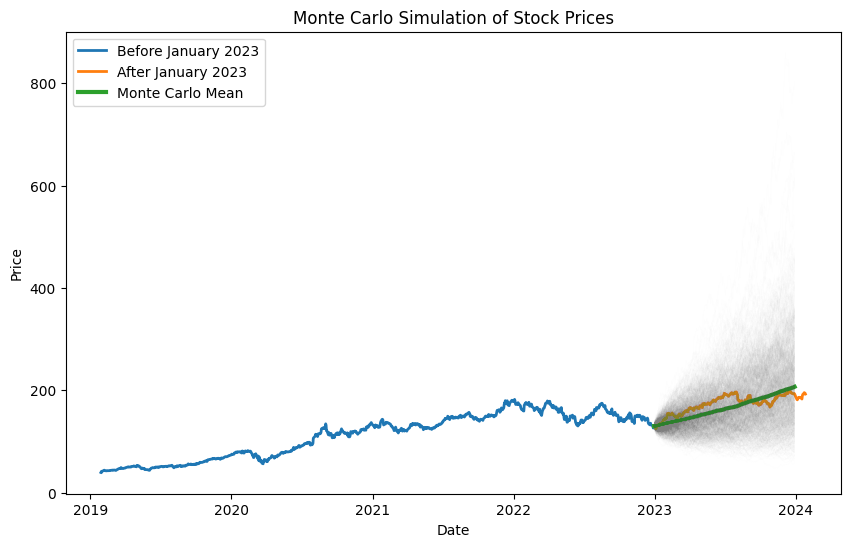

In [32]:
simulation_days = 364
mc_iterations = 1000
start_state = strata.iloc[-1]
mc_prices = monte_carlo_simulation(prices_before_january_2023['Close'], simulation_days, mc_iterations)

# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), prices_before_january_2023['Close'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)
markov_states = markov_chain_simulation(transition_matrix, start_state, simulation_days)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = prices_before_january_2023['date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(pd.to_datetime(prices_before_january_2023['date']), prices_before_january_2023['Close'], label='Before January 2023', linewidth=2)
plt.plot(pd.to_datetime(prices_after_january_2023['date']), prices_after_january_2023['Close'], label='After January 2023', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print("Date of simulation:", simulated_dates[364].date())
simulated_date = simulated_dates[364].date()
real_price = prices_after_january_2023['Close'][18]
real_date = prices_after_january_2023['date'][18]
print(f"Real price on {real_date}: ${real_price:.2f}")
print(f"Real date: {real_date}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")
# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)


# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Average future price after 364 days: $136.65
Date of simulation: 2023-12-29
Real price on 2023-12-29: $192.53
Real date: 2023-12-29
Price difference: $-55.88
Price difference percentage: -29.02%
Model accuracy: 70.98%


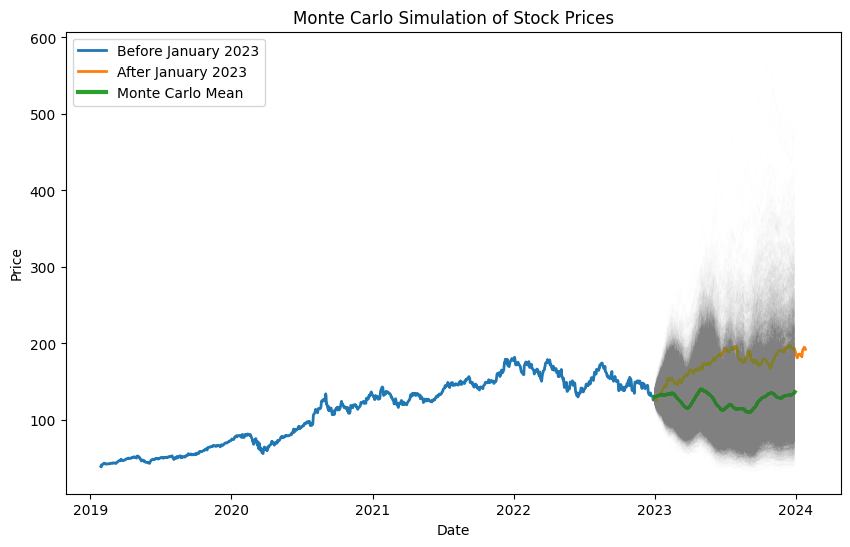

In [51]:
# Define the simulation parameters
simulation_days = 364
mc_iterations = 10000
roulette_chance = 0.01  # The chance of Russian Roulette being played
extreme_factor = 2

# Run the Monte Carlo simulation with Russian Roulette
mc_prices = monte_carlo_simulation_with_dynamic_roulette(prices_before_january_2023['Close'], simulation_days, mc_iterations, roulette_chance, extreme_factor)

# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), prices_before_january_2023['Close'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)

markov_states = markov_chain_simulation(transition_matrix, start_state, simulation_days)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = prices_before_january_2023['date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(pd.to_datetime(prices_before_january_2023['date']), prices_before_january_2023['Close'], label='Before January 2023', linewidth=2)
plt.plot(pd.to_datetime(prices_after_january_2023['date']), prices_after_january_2023['Close'], label='After January 2023', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print("Date of simulation:", simulated_dates[364].date())
simulated_date = simulated_dates[364].date()
real_price = prices_after_january_2023['Close'][18]
real_date = prices_after_january_2023['date'][18]
print(f"Real price on {real_date}: ${real_price:.2f}")
print(f"Real date: {real_date}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")
# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)


# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Average future price after 364 days: $223.28
Date of simulation: 2023-12-29
Real price on 2023-12-29: $192.53
Real date: 2023-12-29
Price difference: $30.75
Price difference percentage: 15.97%
Model accuracy: 84.03%


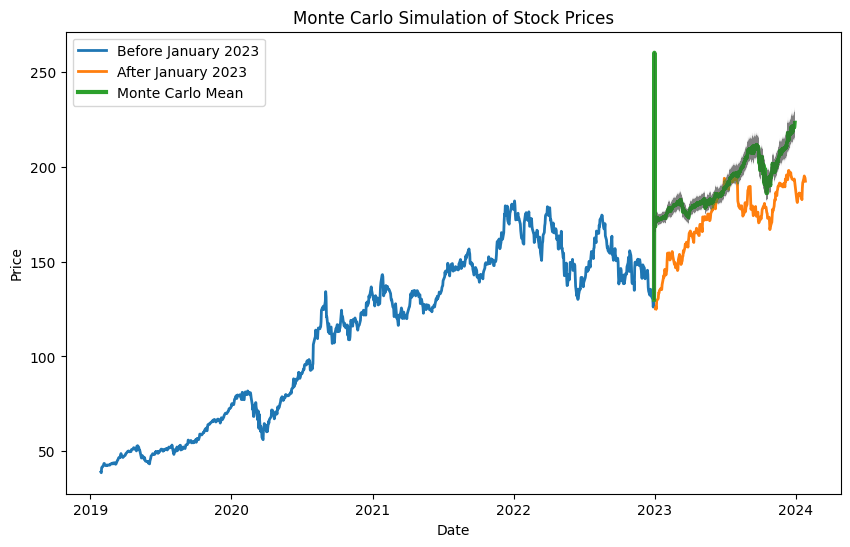

In [62]:
# Define the simulation parameters
simulation_days = 364
mc_iterations = 10000
roulette_chance = 0.01  # The chance of Russian Roulette being played
extreme_factor = 2

# Run the Monte Carlo simulation with Russian Roulette
mc_prices = monte_carlo_simulation_improved(prices_before_january_2023['Close'], simulation_days, mc_iterations)

# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), prices_before_january_2023['Close'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)

markov_states = markov_chain_simulation(transition_matrix, start_state, simulation_days)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = prices_before_january_2023['date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(pd.to_datetime(prices_before_january_2023['date']), prices_before_january_2023['Close'], label='Before January 2023', linewidth=2)
plt.plot(pd.to_datetime(prices_after_january_2023['date']), prices_after_january_2023['Close'], label='After January 2023', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print("Date of simulation:", simulated_dates[364].date())
simulated_date = simulated_dates[364].date()
real_price = prices_after_january_2023['Close'][18]
real_date = prices_after_january_2023['date'][18]
print(f"Real price on {real_date}: ${real_price:.2f}")
print(f"Real date: {real_date}")
print(f"Price difference: ${future_price_mcmc - real_price:.2f}")
print(f"Price difference percentage: {(future_price_mcmc - real_price) / real_price * 100:.2f}%")
print(f"Model accuracy: {100 - abs((future_price_mcmc - real_price) / real_price * 100):.2f}%")
# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)


# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Average future price after 364 days: $346.47
Date of simulation: 2025-01-24


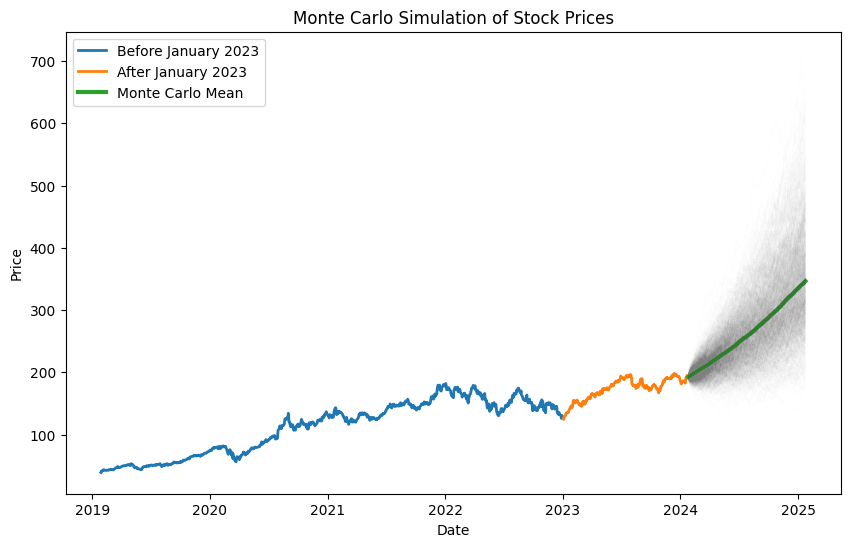

In [22]:
simulation_days = 364
mc_iterations = 1000
start_state = strata.iloc[-1]
mc_prices = monte_carlo_simulation(prices_after_january_2023['Close'], simulation_days, mc_iterations)

# Last closing price repeated for each iteration
last_close_price = np.full((1, mc_iterations), prices_after_january_2023['Close'].iloc[-1])

# Combine the last closing price with the Monte Carlo simulation prices
mc_prices_combined = np.concatenate((last_close_price, mc_prices), axis=0)
markov_states = markov_chain_simulation(transition_matrix, start_state, simulation_days)

# Adjust the periods in the date range to match the number of rows in mc_prices_combined
last_date = prices_after_january_2023['date'].iloc[-1]
simulated_dates = pd.date_range(start=last_date, periods=simulation_days + 1)

# Visualizing the Monte Carlo simulation alongside historical data
plt.figure(figsize=(10, 6))

# Plot historical data
plt.plot(pd.to_datetime(prices_before_january_2023['date']), prices_before_january_2023['Close'], label='Before January 2023', linewidth=2)
plt.plot(pd.to_datetime(prices_after_january_2023['date']), prices_after_january_2023['Close'], label='After January 2023', linewidth=2)

# Taking average of all simulations on the 365th day
future_price_mcmc = np.mean(mc_prices_combined[364, :])
print(f"Average future price after 364 days: ${future_price_mcmc:.2f}")
print("Date of simulation:", simulated_dates[364].date())
simulated_date = simulated_dates[364].date()
# Plot Monte Carlo simulations mean
plt.plot(simulated_dates, mc_prices_combined.mean(axis=1), label='Monte Carlo Mean', linewidth=3)

# Plot each simulation path
for i in range(mc_iterations):
    plt.plot(simulated_dates, mc_prices_combined[:, i], linewidth=0.5, color='gray', alpha=0.01)

plt.title('Monte Carlo Simulation of Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Linear Regression

Mean Squared Error: 274.8312128760471
R2 Score: 0.8703514434620414
Intercept: 49.93723341982451
Slope: 0.11896883046791017
Calculated Stock Price after 365 days: $199.60
Date of prediction: 2024-01-26
Actual Stock Price after 365 days: $192.42
Date of actual price: 2024-01-26
Error: $7.18, Percentage Error: 3.73%
model accuracy: 87.04%


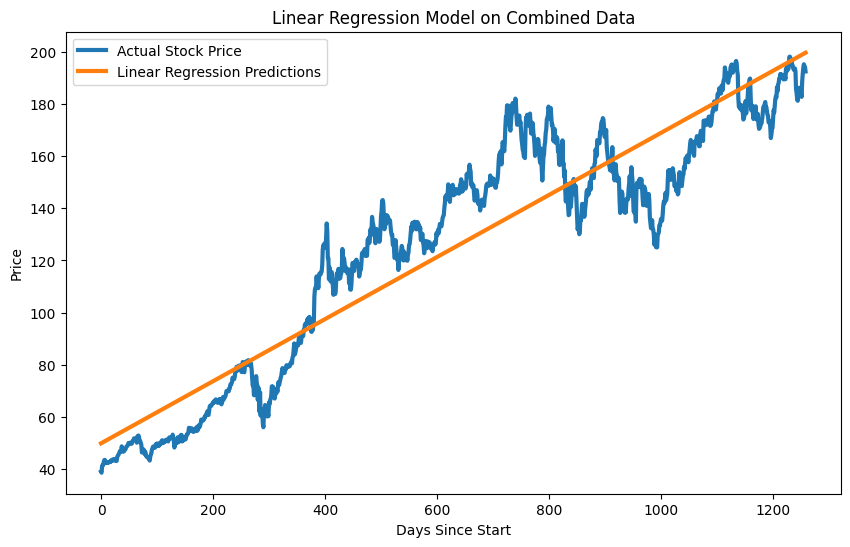

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Combine the data
combined_prices = pd.concat([prices_before_january_2023, prices_after_january_2023])

# Prepare the data for linear regression
# X will be 'days since start', and y will be the stock prices
X_combined = np.arange(len(combined_prices)).reshape(-1, 1)
y_combined = combined_prices['Close'].values

# Split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=0)

# Create and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_combined)

# Evaluate the model
mse = mean_squared_error(y_combined, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {model.score(X_combined, y_combined)}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")
print(f"Calculated Stock Price after 365 days: ${y_pred[-1]:.2f}")
print("Date of prediction:", combined_prices['date'].iloc[-1])
print(f"Actual Stock Price after 365 days: ${combined_prices['Close'].iloc[-1]:.2f}")
print("Date of actual price:", combined_prices['date'].iloc[-1])
print(f"Error: ${y_pred[-1] - combined_prices['Close'].iloc[-1]:.2f}, Percentage Error: {(y_pred[-1] - combined_prices['Close'].iloc[-1]) / combined_prices['Close'].iloc[-1] * 100:.2f}%")
print(f"model accuracy: {model.score(X_combined, y_combined)*100:.2f}%")


# Plot the linear regression model
plt.figure(figsize=(10, 6))
plt.title('Linear Regression Model on Combined Data')
plt.xlabel('Days Since Start')
plt.ylabel('Price')
# use candlestick chart for stock prices
plt.plot(X_combined, y_combined, label='Actual Stock Price', linewidth=3)
plt.plot(X_combined, y_pred, label='Linear Regression Predictions', linewidth=3)
plt.legend()
plt.show()